Execute first cell only for installing required modules 

In [436]:
%pip install chess
%pip install stockfish
# %pip install ipywidgets
"""Install Stockfish Engine on your OS. Refer to Stockfish's official documentation. Restart Kernel Manually after executing this cell"""

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


"Install Stockfish Engine on your OS. Refer to Stockfish's official documentation. Restart Kernel Manually after executing this cell"

Import Required Modules and Specify path

In [437]:
import chess
import os
from stockfish import Stockfish
from dotenv import load_dotenv
import random
import math
# from IPython.display import display
# import ipywidgets as widgets

load_dotenv()
sfPath = os.environ.get("SF_PATH", "stockfish\\stockfish-windows-x86-64-avx2.exe")
printPref = os.environ.get("PRINT_PREF", "chess")

NUM_THREADS = 1
stockfish = [Stockfish(sfPath) for i in range(NUM_THREADS)]

Function Definitions

In [347]:
def generateFen(K, R, k, move = 'w'):
    board_pos = [['.' for _ in range(8)] for _ in range(8)]
    board_pos[K // 8][K % 8] = 'K'
    board_pos[R // 8][R % 8] = 'R'
    board_pos[k // 8][k % 8] = 'k'
    ans = ""
    for row in board_pos:
        count_empty = 0
        for cell in row:
            if cell == '.':
                count_empty += 1
            else:
                if count_empty > 0:
                    ans += str(count_empty)
                    count_empty = 0
                ans += cell
        if count_empty > 0:
            ans += str(count_empty)
        ans += '/'

    ans = ans[:-1]  # Remove the last '/'
    ans += " {} - - 0 1".format(move)
    return ans

def inKingRange(K,k):
    if(abs(K//8-k//8) <= 1 and abs(K%8 - k%8) <= 1):return True
    return False

def inRookRange(R,k,K):
    if R // 8 == k // 8 or R % 8 == k % 8:
        if R // 8 == k // 8 and R // 8 == K // 8:
            if(K % 8 > min(R % 8 , k % 8) and K % 8 < max( R % 8 , k % 8)): return False
            else: return True
        elif R % 8 == k % 8 and R % 8 == K % 8:
            if(K // 8 > min(R // 8 , k // 8) and K // 8 < max(R // 8 , k // 8)): return False
            else: return True
        else: return True
    return False

def fenCheck(K,R,k):
    if(inKingRange(K,k) or inRookRange(R,k,K)): return False
    return True

def getMatrixRepresentationOfFen(fen):
    matrix = [["."] * 8 for _ in range(8)]
    inp = fen.split()[0]
    row = 0
    col = 0

    for char in inp:
        if char.isdigit():
            col += int(char)
        elif char == '/':
            row += 1
            col = 0
        else:
            matrix[row][col] = char
            col += 1

    return matrix

def getAlphabetPosition(fen,alphabet):
    matrix = getMatrixRepresentationOfFen(fen)
    for i in range(0,8):
        temp = -1
        if(alphabet in matrix[i]):
            temp = matrix[i].index(alphabet)
        if (temp == -1):continue
        return i*8 + temp
    return -1

# fen = "6k1/3K4/8/8/8/7R/8/8 w - - 0 1"
# matrix = getMatrixRepresentationOfFen(fen)
# print(matrix)
def isWhiteTurn(fen):
    x = fen.split()[1]
    if(x == 'w'):return True
    return False

def whoPlayedLast(fen):
    x = fen.split()[1]
    if(x == 'w'):return "BLACK"
    return "WHITE"

def checkMate(fen):
    if(chess.Board(fen).is_checkmate()):
        return True
    return False

def checkDraw(fen):
    if(checkStalemate(fen)):
        return True
    if(chess.Board(fen).can_claim_draw()):
        return True
    return False

def checkStalemate(fen):
    if(chess.Board(fen).is_stalemate()):
        return True
    return False

def gameOver(fen):
    if(checkMate(fen) or checkDraw(fen)):
        return True
    return False

def currentFen(i=0):
    return stockfish[i].get_fen_position()

The Algorithm - To choose the next move:

In [645]:
def KingRook_vs_King_Heuristic(K,R,k): # Maximization Heuristic
    if checkStalemate(generateFen(K, R, k,'b')):
        return -math.inf
    
    if inKingRange(k, R) and not inKingRange(K, R):
        return -math.inf
    
    if checkMate(generateFen(K, R, k,'b')):
        return math.inf

    kCol, kRow = k % 8, k // 8
    KCol, KRow = K % 8, K // 8
    RCol, RRow = R % 8, R // 8

    #Enumerating the positions for two specific orientations (x 8 due to board symmetry) that would reduce the heuristic value
    # unfavorablePositions = [[12,13,6],[4,13,6],[30,22,15],[31,22,15],[38,46,55],[39,46,55],[52,53,62],[60,53,62],[51,50,57],[59,50,57],[33,41,48],[32,41,48],[25,17,8],[24,17,8],[11,10,1],[3,10,1]]
    
    hVal = 256

    xR, yR = kCol - RCol, kRow - RRow
    xK, yK = kCol - KCol, kRow - KRow
    numCols, numRows = 0, 0

    if xR < 0: numCols = kCol
    elif xR > 0: numCols = 7 - kCol
    else:
        if xK < 0: numCols = kCol
        elif xK > 0: numCols = 7 - kCol
        else: numCols = max(kCol, 7 - kCol)

    if yR < 0: numRows = kRow
    elif yR > 0: numRows = 7 - kRow
    else:
        if yK < 0: numRows = kRow
        elif yK > 0: numRows = 7 - kRow
        else: numRows = max(kRow, 7 - kRow)

    if abs(xR) < abs(yR):
        hVal += -4 * abs(abs(xR) - 1) + abs(yR) - 4 * abs(abs(xK) - 2) - 4 * abs(abs(yK) - 1) - 4 * numCols
        if abs(yK) == 0 and abs(xK) == 2 and abs(xR) == 0:
            hVal += 64
        if kRow == 0 or kRow == 7 and yK == 1:
            hVal += 32

    else:
        hVal += -4 * abs(abs(yR) - 1) + abs(xR) - 4 * abs(abs(yK) - 2) - 4 * abs(abs(xK) - 1) - 4 * numRows
        if abs(xK) == 0 and abs(yK) == 2 and abs(yR) == 0:
            hVal += 64
        if kCol == 0 or kCol == 7 and xK == 1:
            hVal += 32
    
    return hVal

def KingRook_vs_King_Algorithm(fen, i=0):
    listOfMoves = []
    R = getAlphabetPosition(fen,'R')
    K = getAlphabetPosition(fen,'K')
    k = getAlphabetPosition(fen,'k')

    def isValid(K,R,k):
        if (K==R or R==k or k==K): return False
        if inKingRange(K,k): return False
        return True
    
    def isOnBoard(R,dx):
        row = R//8 + dx[1]
        col = R%8  + dx[0]
        if(max(row,col) >= 8 or min(row,col) < 0):return False
        return True
    
    deltaK = [[0,1],[0,-1],[1,0],[-1,0],[1,1],[1,-1],[-1,1],[-1,-1]]
    deltaR = [[0,1],[0,-1],[1,0],[-1,0]]
    for dR in deltaR:
        if(not isOnBoard(R,dR)): continue
        Rtemp = R + dR[0] + 8*dR[1]
        while(isValid(K,Rtemp,k)):
            listOfMoves.append(['R',K,Rtemp,k])
            if(not isOnBoard(Rtemp,dR)): break
            Rtemp += dR[0] + 8*dR[1]
    for dK in deltaK:
        if(not isOnBoard(K,dK)): continue
        Ktemp = K + dK[0] +8*dK[1]
        if(isValid(Ktemp,R,k)):
            listOfMoves.append(['K',Ktemp,R,k])
    # print(listOfMoves)
    # print(len(listOfMoves))

    bestMove = [-math.inf,-1,-1]
    for move in listOfMoves:
        heuristicValue = KingRook_vs_King_Heuristic(move[1],move[2],move[3])
        if(heuristicValue > bestMove[0] or bestMove[1] == -1):
            bestMove = [heuristicValue,R if move[0] == 'R' else K, move[2] if move[0] == 'R' else move[1]]

    fromStr = "{}{}".format(chr(ord('a') + (bestMove[1] % 8)), 8 - bestMove[1] // 8 )
    toStr = "{}{}".format(chr(ord('a') + (bestMove[2] % 8)), 8 - bestMove[2] // 8 )
    
    moveString = fromStr + toStr
    return moveString

Initialise Board: Create random King-Rook vs King position

c3c5
{'type': 'cp', 'value': 504}
8/8/K3k3/8/8/2R5/8/8 w - - 0 1
16 42 20


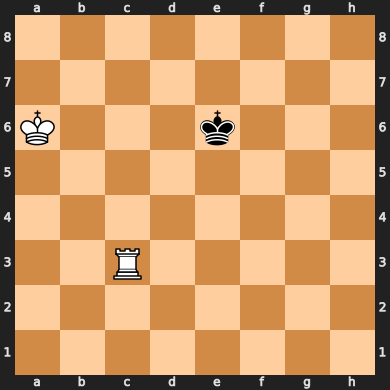

In [349]:
K,R,k = -1, -1, -1
while(not fenCheck(K,R,k)):
    K,R,k = random.sample(range(0,63),3)

fen = generateFen(K,R,k)
stockfish[0].set_fen_position(fen)
board = chess.Board(fen)

print(stockfish[0].get_best_move())
print(stockfish[0].get_evaluation())
print(fen)
print(K,R,k)
board

Play Next Half Move (Run this cell repeatedly to see the game proceed):

a6b5
{'type': 'cp', 'value': 497}
8/8/4k3/1K6/8/2R5/8/8 b - - 1 1


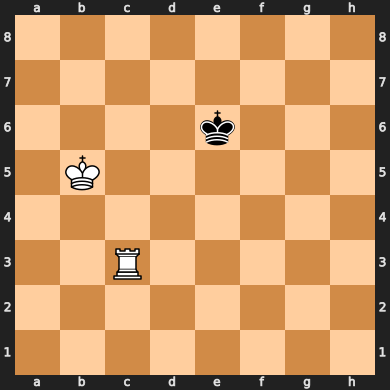

In [350]:
# def nextMove(arg):
if(gameOver(currentFen())):
    print("GAME OVER!")
else:
    move = []
    if(isWhiteTurn(currentFen())):
        move.append(KingRook_vs_King_Algorithm(currentFen()))
    else:
        move.append(stockfish[0].get_best_move())
    stockfish[0].make_moves_from_current_position(move)
    board = chess.Board(currentFen())
    if(checkMate(currentFen())):print("CHECK MATE. ",whoPlayedLast(currentFen())," WINS!")
    elif(checkStalemate(currentFen())):print("STALE MATE. IT'S A DRAW!")
    print(move[0])
print(stockfish[0].get_evaluation())
print(currentFen())
# moveNext_Button = widgets.Button(description = 'Next Move')
# moveNext_Button.on_click(nextMove)
# display(moveNext_Button)
board

Calculating Algorithm Efficiency (Complete Evaluation => estimated time = 4 hours):

In [646]:
totalCount = 0
successCount = 0
inaccuracySum = 0
inaccuracySquareSum = 0
relativeInaccuracySum = 0
denomMetric = 0
moveSeq = []
K,R,k = -1,-1,-1

def playGame(stockfish):
    global moveSeq
    moveSeq = []
    while(not gameOver(currentFen())):
        move = []
        if(isWhiteTurn(currentFen())):
            move.append(KingRook_vs_King_Algorithm(currentFen()))
        else:
            move.append(stockfish.get_best_move())
        stockfish.make_moves_from_current_position(move)
        moveSeq.append(move[0])

def optimalMateIn(stockfish):
    evaluation = stockfish.get_evaluation()
    if(evaluation['type'] != 'mate'):return None
    return evaluation['value']

def numberOfMovesTaken(fen):
    return int(fen.split()[5])

def resetEvaluation():
    global totalCount,successCount,inaccuracySum,inaccuracySquareSum,relativeInaccuracySum,denomMetric
    totalCount,successCount,inaccuracySum,inaccuracySquareSum,relativeInaccuracySum,denomMetric = 0,0,0,0,0,0

def completeEvaluation():
    resetEvaluation()
    global totalCount,successCount,inaccuracySum,inaccuracySquareSum,relativeInaccuracySum,denomMetric
    global K,R,k,failedK,failedR,failedk,failedTestCaseMoveSeq
    for K in range(0,64):           # K
        for R in range(0,64):       # R
            for k in range(0,64):   # k
                if(K == R or R == k or k == K or not fenCheck(K,R,k)):continue
                totalCount += 1

                stockfish[0].set_fen_position(generateFen(K,R,k))
                fastestMate = optimalMateIn(stockfish[0])
                playGame(stockfish[0])
                if(not checkMate(currentFen())): 
                    # print(K,R,k) #Failed test case
                    if(failedTestCaseMoveSeq is None):
                        failedTestCaseMoveSeq = moveSeq #First failed test case data stored
                        failedK,failedR,failedk = K,R,k
                    continue

                successCount += 1
                if(fastestMate is None):continue

                moveCount = numberOfMovesTaken(currentFen())
                inaccuracy = moveCount - fastestMate
                if(inaccuracy < 0): inaccuracy = 0
                inaccuracySum += inaccuracy
                inaccuracySquareSum += inaccuracy*inaccuracy
                relativeInaccuracySum += inaccuracy/fastestMate

def sampleSpaceEvaluation(numberOfTrials):
    resetEvaluation()
    global totalCount,successCount,inaccuracySum,inaccuracySquareSum,relativeInaccuracySum,denomMetric
    global K,R,k,failedK,failedR,failedk,failedTestCaseMoveSeq
    failedTestCaseMoveSeq = None
    for _ in range(0,numberOfTrials):
        K,R,k = -1,-1,-1
        while(not fenCheck(K,R,k)):
            K,R,k = random.sample(range(0,63),3)
        totalCount += 1
        stockfish[0].set_fen_position(generateFen(K,R,k))
        fastestMate = optimalMateIn(stockfish[0])
        playGame(stockfish[0])
        if(not checkMate(currentFen())): 
            # print(K,R,k) #Failed test case
            if(failedTestCaseMoveSeq is None):
                failedTestCaseMoveSeq = moveSeq #First failed test case data stored
                failedK,failedR,failedk = K,R,k
            continue

        successCount += 1
        if(fastestMate is None):continue

        denomMetric += 1
        moveCount = numberOfMovesTaken(currentFen())
        inaccuracy = moveCount - fastestMate
        if(inaccuracy < 0): inaccuracy = 0
        inaccuracySum += inaccuracy
        inaccuracySquareSum += inaccuracy*inaccuracy
        relativeInaccuracySum += inaccuracy/fastestMate


#completeEvaluation()
sampleSpaceEvaluation(100)
print("Total number of valid positions sampled = ", totalCount)
print("Algorithm success rate  = ",successCount/totalCount * 100,"%")
if (successCount == totalCount and denomMetric != 0):
    print("Mean inaccuracy = ",inaccuracySum/denomMetric)
    print("Root mean squared inaccuracy = ",math.sqrt(inaccuracySquareSum/denomMetric))
    print("Mean relative inaccuracy = ",relativeInaccuracySum/denomMetric)
elif (successCount != totalCount):
    print("Accuracy not 100%")

Total number of valid positions sampled =  100
Algorithm success rate  =  74.0 %
Mean inaccuracy =  7.466666666666667
Root mean squared inaccuracy =  13.185851002747857
Mean relative inaccuracy =  1.4646275946275948


Debugging purposes only (FailedTestCaseMoveSeq and failedK,failedR,failedk would store the data for the first failed test case - if exists ;):

In [614]:
#Initialise position
i = -1
print(failedTestCaseMoveSeq)
failedFen = generateFen(failedK, failedR, failedk)
stockfish[0].set_fen_position(failedFen)
failedK,failedR,failedk

['g1d1', 'c5c4', 'f2e3', 'c4c3', 'd1c1', 'c3b2', 'c1c8', 'b2b3', 'e3d2', 'b3b4', 'd2d3', 'b4b5', 'd3d4', 'b5b6', 'd4d5', 'b6b7', 'c8c1', 'b7b6', 'c1b1', 'b6c7', 'b1c1', 'c7d7', 'c1c6', 'd7e7', 'c6a6', 'e7f7', 'd5e5', 'f7g7', 'e5f5', 'g7f7', 'a6a7', 'f7e8', 'f5f6', 'e8d8', 'a7a1', 'd8c7', 'a1c1', 'c7d6', 'c1d1', 'd6c5', 'f6e6', 'c5c4', 'e6e5', 'c4b3', 'd1c1', 'b3b2', 'c1c8', 'b2b1', 'e5d4', 'b1b2', 'd4d3', 'b2b3', 'c8b8', 'b3a4', 'd3c3', 'a4a5', 'b8b4', 'a5a6', 'b4h4', 'a6b6', 'h4h5', 'b6c6', 'c3d4', 'c6d7', 'h5h6', 'd7e7', 'd4d5', 'e7f7', 'd5e5', 'f7g7', 'h6a6', 'g7f7', 'a6a7', 'f7g6', 'a7a6', 'g6g5', 'a6a4', 'g5g6', 'a4f4', 'g6g5', 'f4f1', 'g5g4', 'f1f8', 'g4g3', 'e5e4', 'g3h4', 'f8g8', 'h4h5', 'e4f4', 'h5h6', 'f4f5', 'h6h7', 'g8g1', 'h7h6', 'g1h1', 'h6g7', 'h1g1', 'g7f7', 'g1g6']


(53, 62, 26)

8/2k5/8/3K4/8/8/8/1R6 w - - 20 11


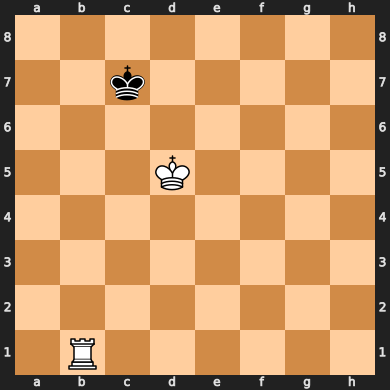

In [634]:
#Play next half move
if i < len(failedTestCaseMoveSeq) - 1:
    i+=1
if i == -1:
    pass
elif i < len(failedTestCaseMoveSeq):
    stockfish[0].set_fen_position(failedFen)
    stockfish[0].make_moves_from_current_position(failedTestCaseMoveSeq[:i+1])
print(currentFen())
chess.Board(stockfish[0].get_fen_position())